In [1]:
import pathlib
import sys

path = pathlib.Path("..")

sys.path.insert(0, str(path.resolve()))

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from scipy import stats

In [3]:
from src.Database import Database

In [4]:
with Database() as cnx:
    all_books = cnx.all_books()
    books = cnx.completed_books()
    all_purchases = cnx.all_purchases()

In [5]:
# Corrects data types and slices data to look at only books finished in 2015 and beyond
books["started"] = pd.to_datetime(books["started"])
books["finished"] = pd.to_datetime(books["finished"])
books = books[books["finished"].dt.year >= 2015].copy()

In [6]:
def make_timeline():
    """Creates a custom axes to order the matplotlib visuals on"""
    month_order = [
        "January", "February", "March",
        "April", "May", "June",
        "July", "August", "September",
        "October", "November", "December"
    ]
    time_order = []
    for year in ["2015", "2016", "2017", "2018", "2019", "2020", "2021"]:
        for month in month_order:
            time_order.append(month + " " + year)
    return time_order

In [7]:
def add_timeline(df):
    """Adds the timeline to df as a categorical variable"""
    timeline = make_timeline()
    df_timeline = df.copy()
    missing = ["August 2019", "September 2019", "November 2019", "November 2017"]
    
    keys = df_timeline["month_read"] + " " + df_timeline["year_read"].astype("str")
    
    df_timeline["timeline"] = pd.Categorical(
        keys,
        [key for key in timeline if key in np.append(keys.values, missing)],
        ordered=True
    )
    return df_timeline.sort_values(by="timeline")

In [8]:
def format_grouped_by_date(df, col, estimator):
    """Creates a grouped df with values aggregated on the passed value 'estimator'"""
    methods = {
        "count": pd.Series.count, 
        "mean": pd.Series.mean, 
        "max": pd.Series.max
    }
    return (
        add_timeline(df)[[col, "timeline"]]
        .groupby("timeline")[col]
        .apply(methods[estimator])
        .reset_index()
    )

In [9]:
def books_over_time(df, ax=None, show=False, pdf=None):
    """Plots the number of books read over time"""
    
    books_over_time = format_grouped_by_date(df, "title", "count")
    timeline = books_over_time["timeline"]
    x_vals = [label if label.startswith("January") else "" for label in timeline]
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(18,8))
    
    ax.plot(timeline, books_over_time["title"], marker="o")
    plt.xticks(range(len(x_vals)), x_vals, rotation=65, ha="right")
    plt.title("Number of Books Over Time")
    plt.xlabel("")
    plt.ylabel("Number of Books")
    plt.axhline(
        np.mean(books_over_time["title"]),
        label="Average books in a month: " + str(np.ceil(np.mean(books_over_time["title"]))),
        color="orange"
    )
    plt.axvline("October 2018", label="Move to Nor Cal", color="red", linestyle="--")
    plt.axvline("August 2020", label="Move to Missouri", color="orange", linestyle="--")
    plt.axvline("June 2017", label="Graduated From UCI", color="violet", linestyle="--")
    plt.axvline("July 2021", label="Move Back to California", color="teal", linestyle="--")
    plt.legend(loc=3)
    
    if pdf:
        pdf.savefig(bbox_inches="tight")
        plt.close("all")
    if show:
        plt.show()

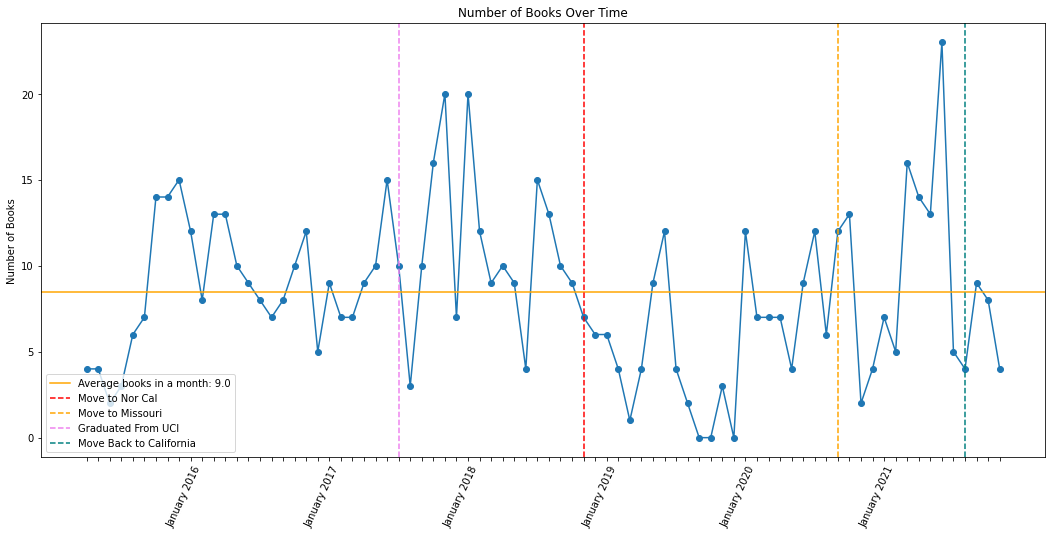

In [10]:
# plt.figure(figsize=(18, 8))
# ax = plt.subplot(122)
books_over_time(books,  show=True)

In [11]:
def pages_read_over_time(df, ax=None, show=False, pdf=None):
    """Plots the total pages in books read over time"""
    
    pages_over_time = format_grouped_by_date(books, "pages", "mean")
    timeline = pages_over_time["timeline"]
    x_vals = [label if label.startswith("January") else "" for label in timeline]
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(18,8))
    ax.plot(timeline, pages_over_time["pages"], marker="o")
    plt.axis([-3, len(x_vals)+3, 0, 700])
    plt.xticks(range(len(x_vals)), x_vals, rotation=65, ha="right")
    plt.title("Average Pages Over Time")
    plt.xlabel("")
    plt.ylabel("Average Number of Pages")
    plt.axhline(
        np.mean(pages_over_time["pages"]), 
        label="Average pages in a month: " + str(np.ceil(np.mean(pages_over_time["pages"]))), 
        color="orange"
    )

    plt.axvline("October 2018", label="Move to Northern California", color="red", linestyle="--")
    plt.axvline("August 2020", label="Move to Missouri", color="orange", linestyle="--")
    plt.axvline("June 2017", label="Graduated from UCI", color="violet", linestyle="--")
    plt.axvline("July 2021", label="Move Back to California", color="teal", linestyle="--")
    plt.legend(loc=3)
    
    if pdf:
        pdf.savefig(bbox_inches="tight")
        plt.close("all")
    if show:
        plt.show()

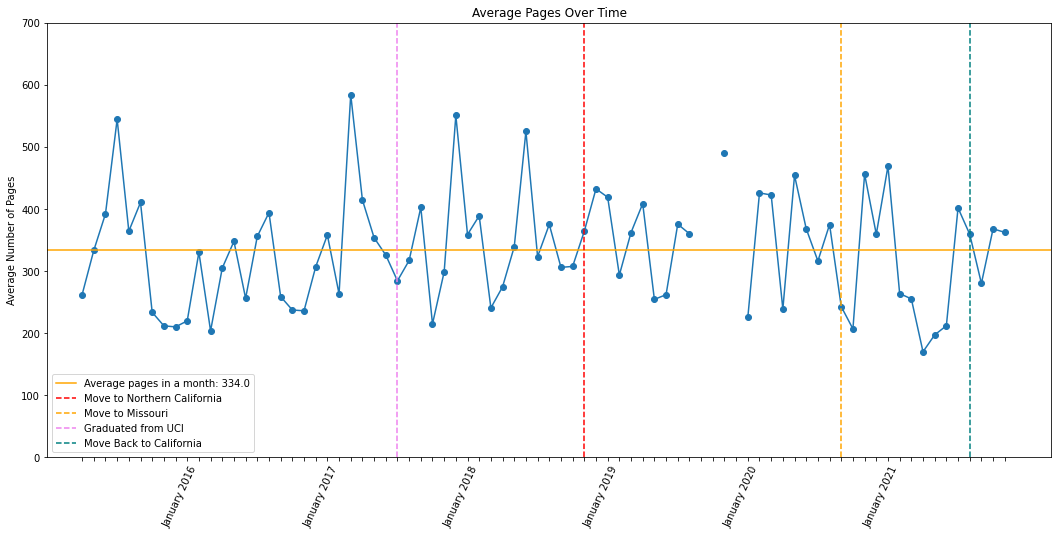

In [12]:
# ax = plt.subplot(111)
pages_read_over_time(books, show=True)

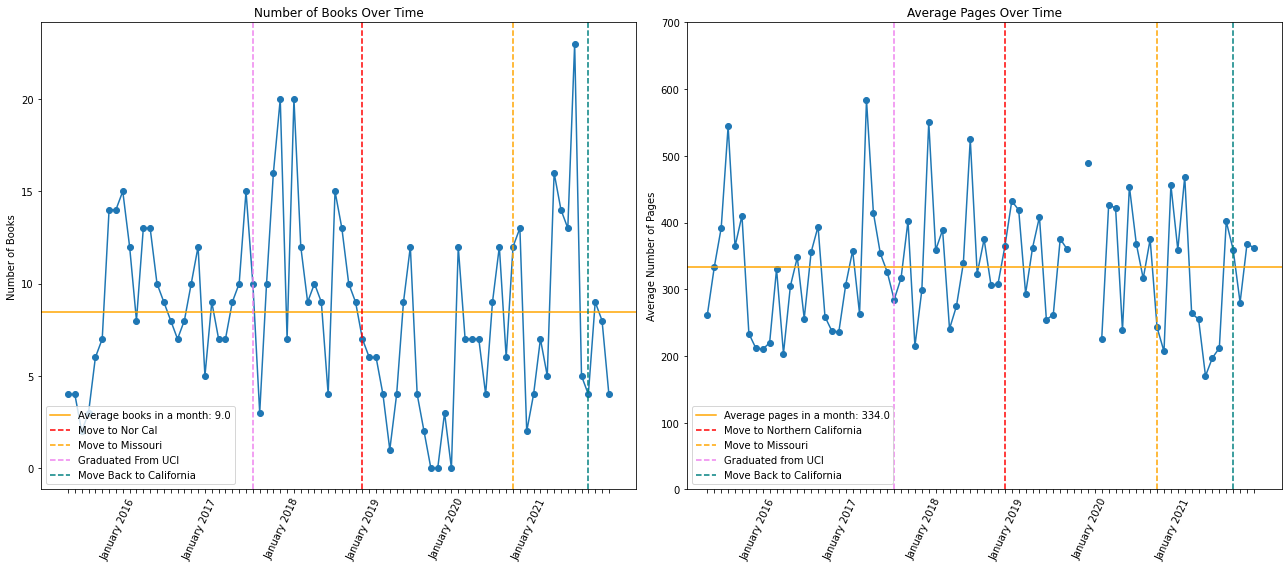

In [13]:
plt.figure(figsize=(18, 8))
ax1 = plt.subplot(121)
books_over_time(books, ax1)

ax2 = plt.subplot(122)
pages_read_over_time(books, ax2)
plt.tight_layout()
plt.show()

In [14]:
def book_length_hist(df, ax=None, show=False, pdf=None):
    """Creates a histogram to demonstrate the distribution of book length (number of pages) across books read"""
    
    page_counts = df["pages"].dropna().copy()
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(18,8))
    ax.hist(page_counts, bins=30, alpha=0.7)
    
    plt.title("Book Lengths")
    plt.ylabel("Number of Books")
    plt.xlabel("Number of Pages")
    
    mean_pages = np.mean(page_counts)
    median_pages = np.median(page_counts)
    std_pages = np.std(page_counts)
    
    plt.axvline(mean_pages, color="orange", label=f"Average Number of Pages - {np.ceil(mean_pages)}")
    plt.axvline(median_pages, color="green", label=f"Median Page Count - {np.ceil(median_pages)}")
    plt.axvline(mean_pages + std_pages, linestyle="--", color="red", label=f"1 STD Away From Mean - {np.round(std_pages, 2)}")
    plt.axvline(mean_pages - std_pages, linestyle="--", color="red")
    plt.legend()
    
    if pdf:
        pdf.savefig(bbox_inches="tight")
        plt.close("all")
    if show:
        plt.show()

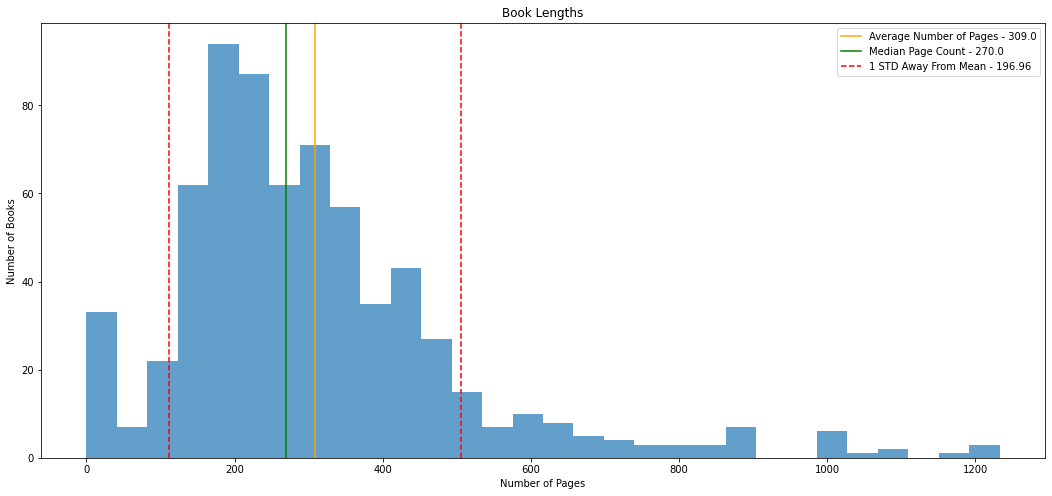

In [15]:
# plt.figure(figsize=(18, 8))
# ax = plt.subplot(121)
book_length_hist(books, show=True)

In [16]:
def make_seasons_table(df):
    """Creates a table that separates books based on which season they were finished in"""
    
    spring = ["March", "April", "May"]
    summer = ["June", "July", "August"]
    fall = ["September", "October", "November"]
    winter = ["December", "January", "February"]

    book_seasons = df.copy()

    book_seasons.loc[book_seasons["finished"].dt.month_name().isin(spring), "season"] = "spring"
    book_seasons.loc[book_seasons["finished"].dt.month_name().isin(summer), "season"] = "summer"
    book_seasons.loc[book_seasons["finished"].dt.month_name().isin(fall), "season"] = "fall"
    book_seasons.loc[book_seasons["finished"].dt.month_name().isin(winter), "season"] = "winter"
    
    return book_seasons

In [17]:
def books_by_season(df, ax=None, show=False, pdf=None):
    """Plots the number of books completed in each season of the year"""
    
    book_seasons = make_seasons_table(df)[["title", "season"]]
    counts_by_season = book_seasons.groupby("season")["title"].count().reset_index()
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(18,8))
    ax.bar(range(4), counts_by_season["title"])
    ax.set_xticks(range(4))
    ax.set_xticklabels(counts_by_season["season"])
    ax.set_title("Books By Season")
    ax.set_xlabel("")
    ax.set_ylabel("Number of Books")
    
    if pdf:
        pdf.savefig(bbox_inches="tight")
    if show:
        plt.show()

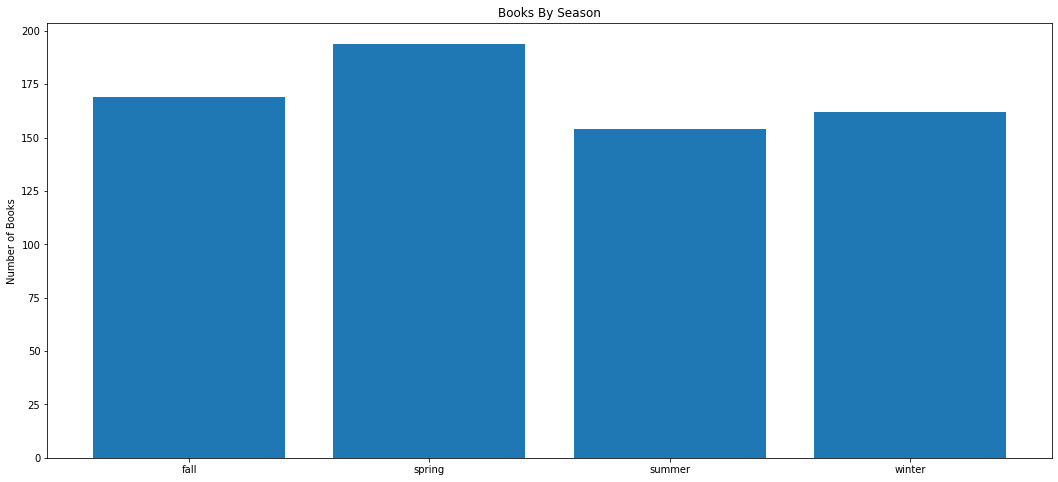

In [18]:
# plt.figure(figsize=(18,8))
books_by_season(books, show=True)

In [19]:
def pages_by_season(df, ax=None, show=False, pdf=None):
    """Plots the total number of pages read for books finished in each season of the year"""
    
    book_seasons = make_seasons_table(books)[["pages", "season"]]
    pages_by_season = book_seasons.groupby("season")["pages"].mean().reset_index()
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(18,8))
    ax.bar(range(4), pages_by_season["pages"])
    ax.set_xticks(range(4))
    ax.set_xticklabels(pages_by_season["season"], rotation=0)
    ax.set_title("Pages by Season")
    ax.set_xlabel("")
    ax.set_ylabel("Average Number of Pages")
    
    if pdf:
        pdf.savefig(bbox_inches="tight")
        plt.close("all")
    if show:
        plt.show()

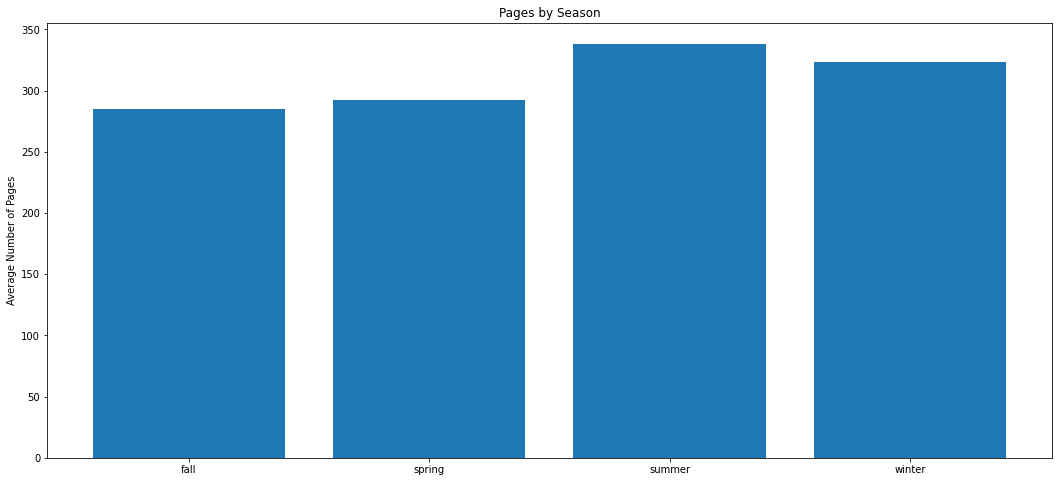

In [20]:
# plt.figure(figsize=(18, 8))
pages_by_season(books, show=True)

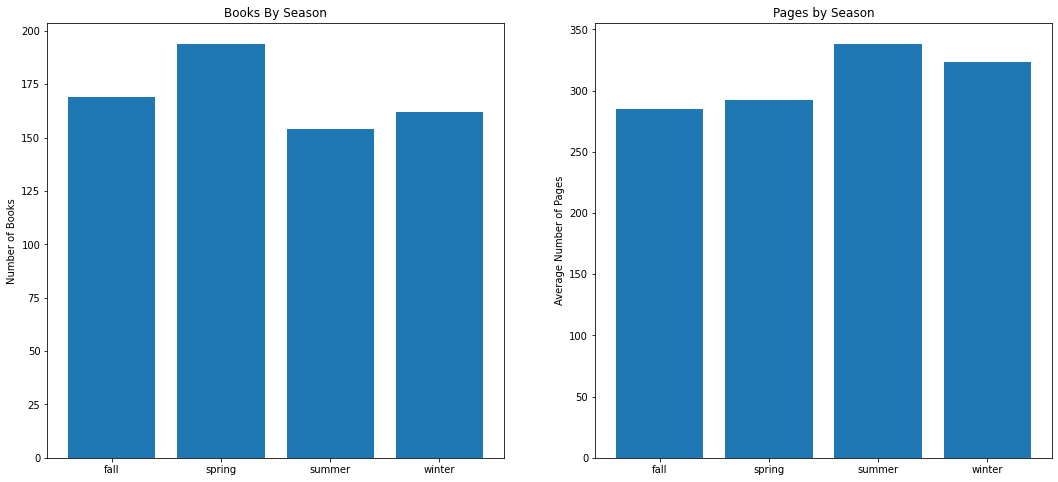

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(18,8))
books_by_season(books, ax=ax[0])
pages_by_season(books, ax=ax[1])
plt.show()

In [22]:
def add_percent_f_nf(df):
    """Adds a column for the percent share of f (fiction) vs nf (non-fiction)"""
    
    f_nf = (
        df
        .copy()
        .groupby("f_nf")["title"]
        .count()
        .reset_index()
    )
    f_nf["pcts"] = f_nf["title"] / f_nf["title"].sum()
    return f_nf
    

In [23]:
def fiction_vs_nonfiction(df, ax=None, show=False, pdf=None):
    """Creates a donut chart to visualize completed fiction vs nonfiction books"""
    
    f_nf = add_percent_f_nf(df)
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(18,8))
    ax.pie(f_nf["pcts"], autopct="%0.1f%%", pctdistance=1.15, startangle=270, explode=[0.05,0])
    ax.pie(f_nf["pcts"], radius=0.8, colors=["white", "white"], explode=[0.05, 0], startangle=270, wedgeprops={"edgecolor": "white"})
    ax.axis("equal")
    ax.legend(f_nf["f_nf"])
    ax.set_title("Fiction / Nonfiction Proportions")
    
    if pdf:
        pdf.savefig(bbox_inches="tight")
        plt.close("all")
    if show:
        plt.show()

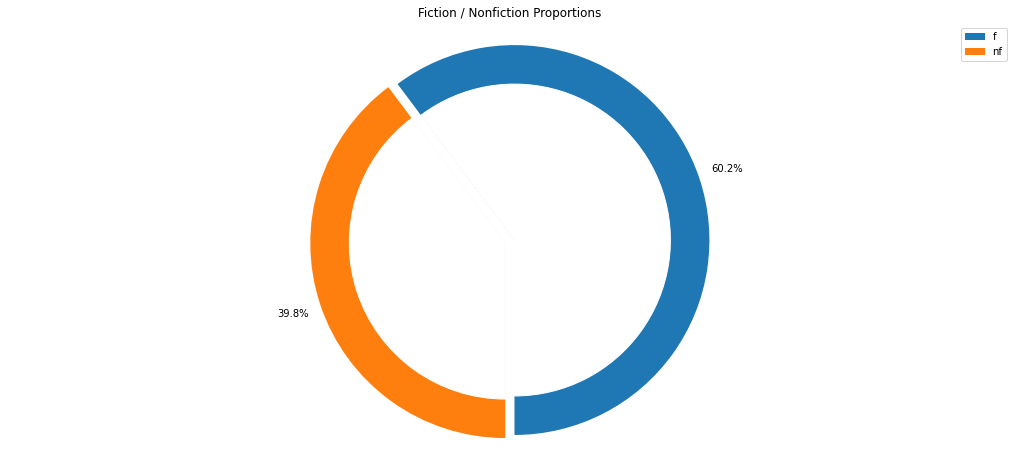

In [24]:
fiction_vs_nonfiction(books, show=True)

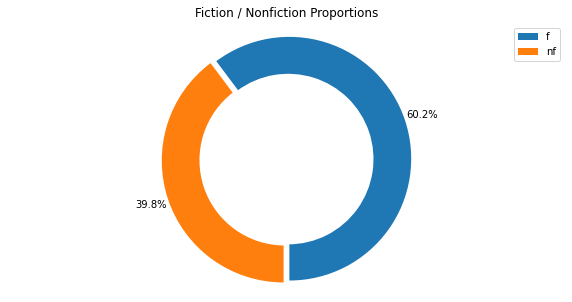

In [25]:
plt.close("all")

f_nf = books[["title", "f_nf"]].copy()
f_nf = f_nf.groupby("f_nf")["title"].count().reset_index()
f_nf["pcts"] = f_nf["title"].div(f_nf["title"].sum())

plt.figure(figsize=(10, 5))
ax = plt.subplot()
plt.pie(f_nf["pcts"], autopct="%0.1f%%", pctdistance=1.15, startangle=270, explode=[0.05, 0])
plt.pie(f_nf["pcts"], radius=0.7, colors=["white", "white"], explode=[0.04, -0.01], startangle=270)
plt.axis("equal")
plt.legend(f_nf["f_nf"])

plt.title("Fiction / Nonfiction Proportions")
# pdf_test.savefig()
plt.show()

In [26]:
def add_pct_of_rating(df):
    """Adds the percentage of each rating category (1 - 5)"""
    
    ratings = (
        df[["title", "rating"]]
        .copy()
        .dropna()
        .groupby("rating")["title"]
        .count()
        .reset_index()
    )
    ratings["pct_of_total"] = ratings["title"] / ratings["title"].sum()
    return ratings

In [27]:
def rating_spread(df, ax=None, show=False, pdf=None):
    """Creates a donut chart to visualize the spread of ratings for books read"""
    
    ratings = add_pct_of_rating(df)
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(18,8))
    percents = ratings["pct_of_total"]
    explode = [0, 0, 0, 0, 0.1, 0.1]
    ax.pie(percents, autopct="%0.1f%%", pctdistance=1.10, explode=explode)
    ax.pie(percents, colors=["white"]*len(percents), radius=0.7, center=(0,0), explode=explode, wedgeprops={"edgecolor": "white"})
    ax.legend(ratings["rating"])
    ax.set_title("Proportion of Ratings") # Using these instead of plt.title so that it stays with the axis in custom configs
    ax.axis("equal")
    if pdf:
        pdf.savefig(bbox_inches="tight")
        plt.close("all")
    if show:
        plt.show()

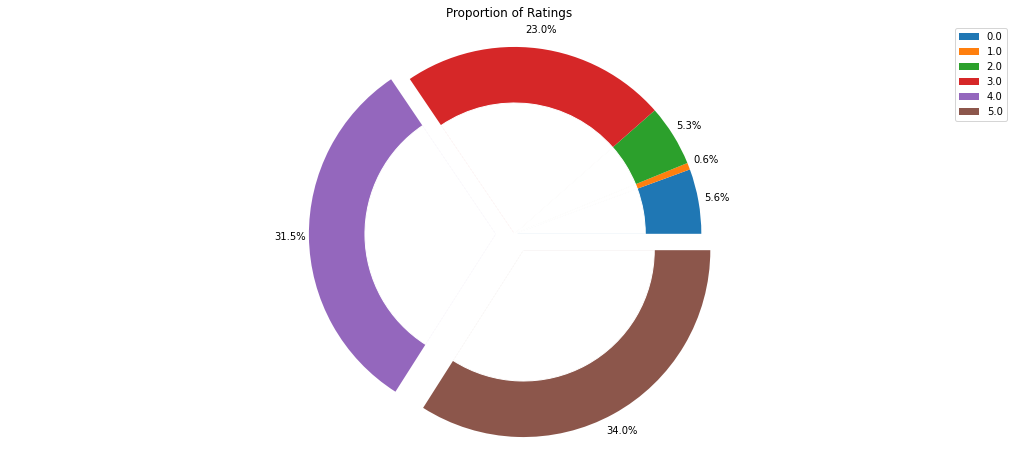

In [28]:
rating_spread(books, show=True)

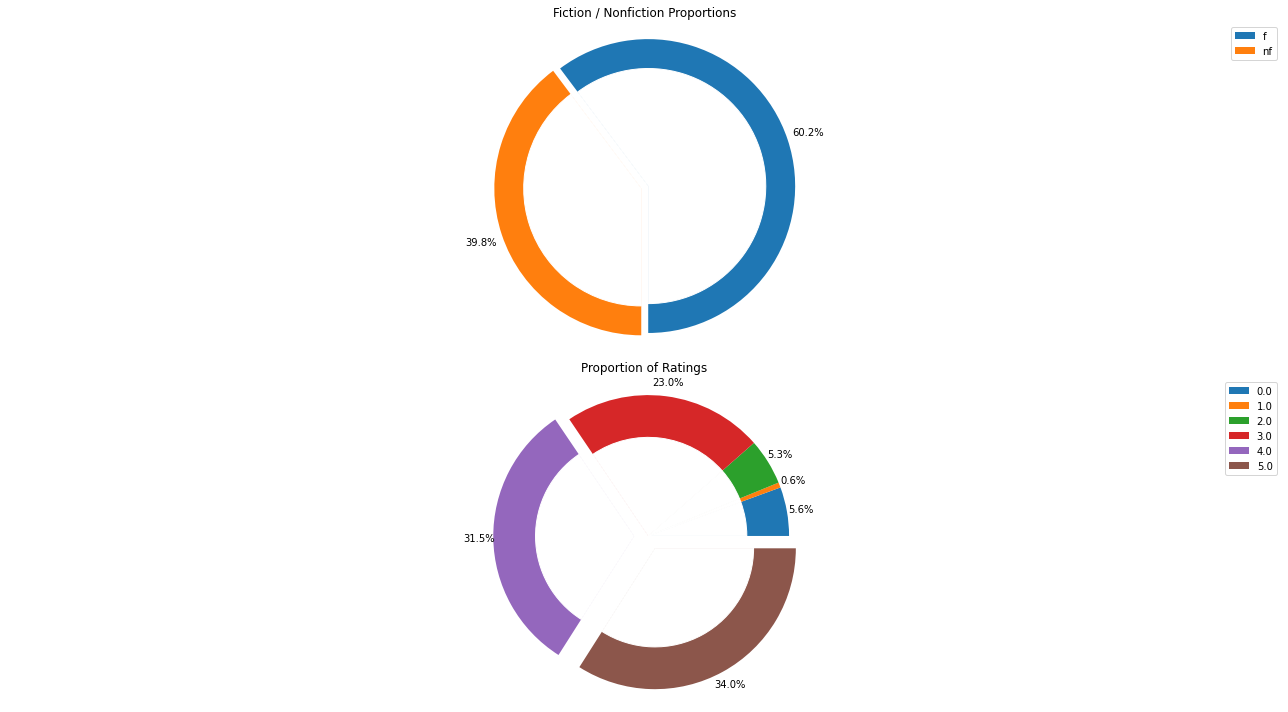

In [29]:
fig, axs = plt.subplots(2, 1, figsize=(18,10))
fiction_vs_nonfiction(books, ax=axs[0])
rating_spread(books, ax=axs[1])
plt.tight_layout()
plt.show()

In [30]:
def group_by_genre(df):
    """Creates a grouped table with number of books read by genre"""
    
    return (
        df
        .copy()
        .dropna(subset=["genre"])
        .groupby("genre")["title"]
        .count()
        .reset_index()
        .sort_values(
            by="title",
            ascending=False
        )
    )

In [31]:
def books_by_genre(df, ax=None, show=False, pdf=None):
    """Plots the number of books by genre"""
    
    books_by_genre = group_by_genre(df)
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(18, 8))
    x_vals = range(len(books_by_genre["genre"]))
    ax.bar(x_vals, books_by_genre["title"])
    ax.set_xticks(x_vals)
    ax.set_xticklabels(books_by_genre["genre"],rotation=75, ha="right")
    ax.set_title("Books by Genre")
    ax.set_xlabel("")
    ax.set_ylabel("Number of Books")
    
    if pdf:
        pdf.savefig(bbox_inches="tight")
        plt.close("all")
    if show:
        plt.show()

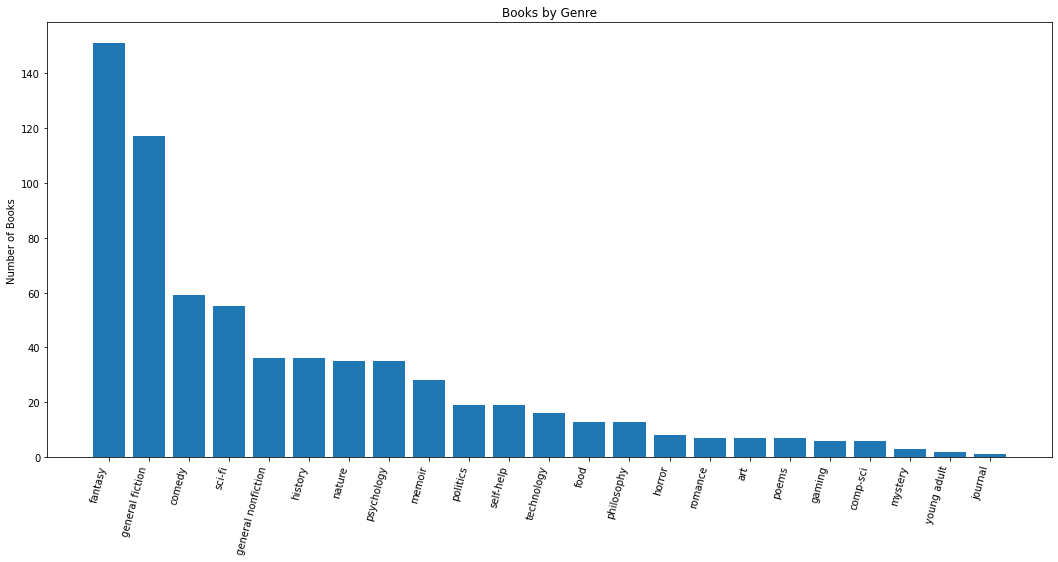

In [32]:
books_by_genre(books, show=True)

In [33]:
def group_by_source(df):
    """Creates a grouped table with number of books read by source"""
    
    return (
        df
        .copy()
        .dropna(subset=["source"])
        .groupby("source")["title"]
        .count()
        .reset_index()
        .sort_values(
            by="title",
            ascending=False
        )
    )

In [34]:
def books_by_source(df, ax=None, show=False, pdf=None):
    """Plots the number of books read by source"""
    
    books_by_source = group_by_source(df)
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(18, 8))
    x_vals = range(len(books_by_source["source"]))
    ax.bar(x_vals, books_by_source["title"])
    ax.set_xticks(x_vals)
    ax.set_xticklabels(books_by_source["source"],rotation=75, ha="right")
    ax.set_title("Books by Source")
    ax.set_xlabel("")
    ax.set_ylabel("Number of Books")
    
    if pdf:
        pdf.savefig(bbox_inches="tight")
        plt.close("all")
    if show:
        plt.show()

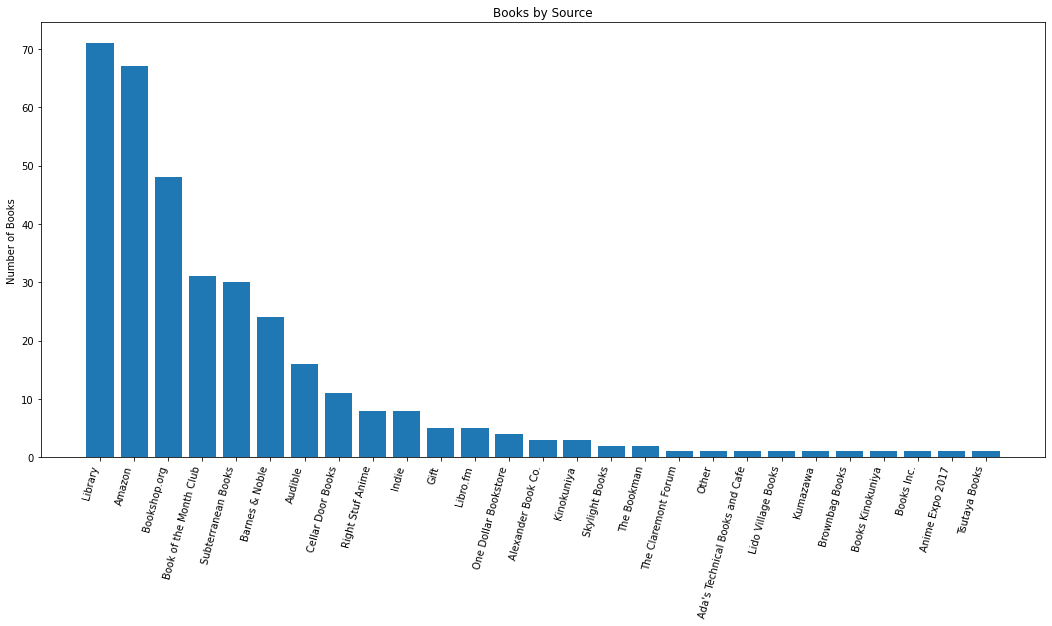

In [35]:
books_by_source(books)

In [36]:
def get_books_read_in_pub_year(df, year):
    """Returns all the books published in the passed year"""
    
    return df[
        (df["finished"].dt.year == year)
        & (df["year"] == year)
    ].copy()

def get_y_vals_by_year(df, year_list):
    """Returns the length of the bar for each year in year_list"""
    
    return [
        len(get_books_read_in_pub_year(df, year)) / len(df[df["finished"].dt.year == year])
        for year in year_list
    ]

def get_totals(df, year_list):
    """Returns the total books read in a year"""
    return [
        len(df[df["finished"].dt.year == year])
        for year in year_list
    ]

In [37]:
def top_bars(ax, y_vals):
    """Plots the top bars of the visual, with bottom value set at hight of bottom bar"""
    
    ax.bar(range(6), [1-y_val for y_val in y_vals], bottom=y_vals, label="Backlog")

In [38]:
def current_releases(df, ax=None, show=False, pdf=None):
    """
    Plots the proportion of books that were read in the same year they were published vs those
    that were read in years after their publication date
    """
    x_vals = ["2016", "2017", "2018", "2019", "2020", "2021"]
    year_list = list(map(int, x_vals))
    y_vals = get_y_vals_by_year(df, year_list)
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(18, 8))
    
    ax.bar(range(6), y_vals, label="Read in Year Pubbed")
    
    for idx, value in enumerate(y_vals):
        ax.text(
            idx, 
            value+0.025, 
            str(round(value, 2)*100) + "%",
            horizontalalignment="center", 
            fontweight="bold", 
            fontsize=14
        )
    totals = get_totals(df, year_list)
    for idx, value in enumerate(totals):
        ax.text(idx, 0.8, "Total\nBooks:\n"+ str(value), horizontalalignment="center", fontweight="bold")
    top_bars(ax, y_vals)
    ax.set_xticks(range(6))
    ax.set_xticklabels(x_vals)
    ax.set_title("Books Read in Year of Publication")
    ax.set_ylabel("Proportion of Books")
    ax.set_xlabel("")
    ax.legend()
    
    if pdf:
        pdf.savefig(bbox_inches="tight")
        plt.close("all")
    if show:
        plt.show()

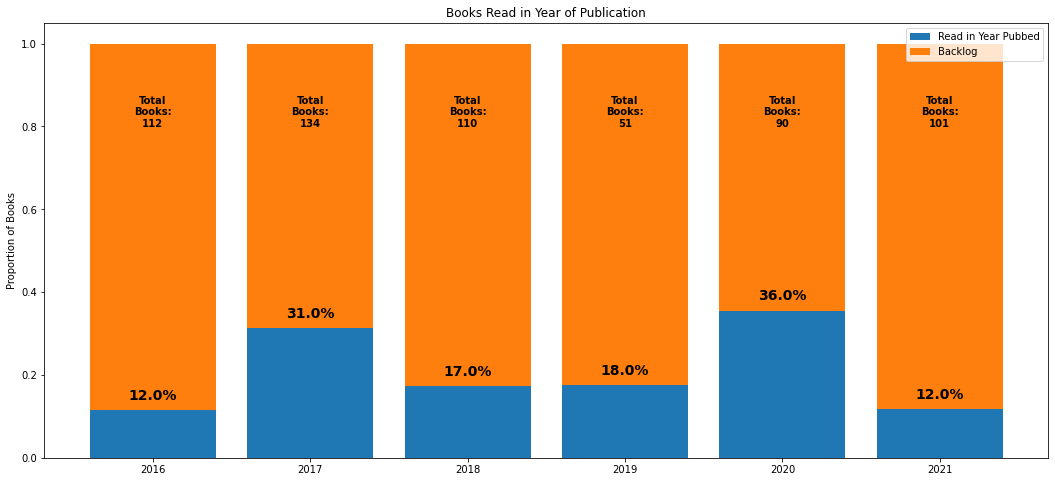

In [39]:
current_releases(books, show=True)

In [40]:
def books_by_year(df, ax=None, show=False, pdf=None):
    """Plots the total number of books read in each year to compare with average"""
    
    x_values = ["2016", "2017", "2018", "2019", "2020", "2021"]
    year_list = list(map(int, x_values))
    totals = get_totals(df, year_list)
    mean_totals = np.mean(totals)
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(18, 8))
    ax.bar(range(6), totals)
    ax.set_xticks(range(6))
    ax.set_xticklabels(x_values)
    plt.axhline(mean_totals, label=f"Avg Per Year - {mean_totals}")
    ax.set_title("Totals Per Year")
    ax.set_ylabel("Number of Books")
    ax.set_xlabel("")
    ax.legend()
    
    if pdf:
        pdf.savefig(bbox_inches="tight")
        plt.close("all")
    if show:
        plt.show()

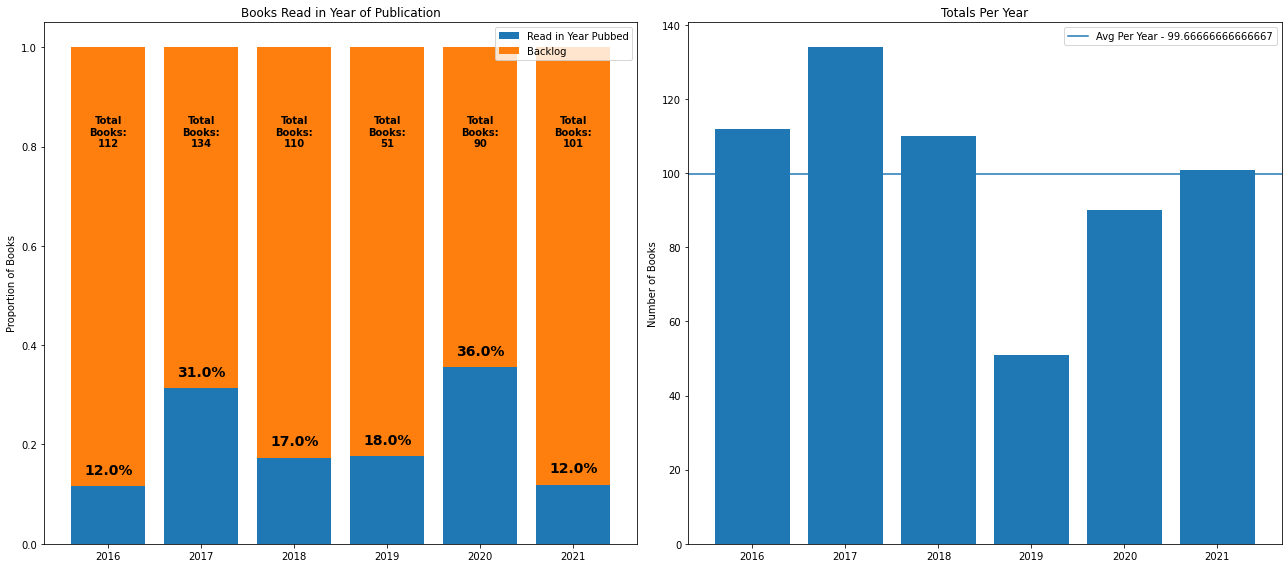

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))
current_releases(books, ax=axs[0])
books_by_year(books, ax=axs[1])
plt.tight_layout()
plt.show()

In [42]:
def group_by_format(df):
    """Creates a grouped table with number of books read by format"""
    
    return (
        df[~df["finished"].isna()]
        .copy()
        .groupby("format")["title"]
        .count()
        .reset_index()
        .sort_values(by="title", ascending=False)
    )

In [43]:
def books_by_format(df, ax=None, show=False, pdf=None):
    """Plots the number of books read by format"""
    
    books_by_format = group_by_format(df)
    x_vals = books_by_format["format"]
    y_vals = books_by_format["title"]
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(18, 8))
    ax.bar(range(len(x_vals)), y_vals)
    ax.set_xticks(range(len(x_vals)))
    ax.set_xticklabels(x_vals)
    ax.set_title("Book by Format")
    plt.xlabel("")
    plt.ylabel("Number of Books")
    
    if pdf:
        pdf.savefig(bbox_inches="tight")
        plt.close("all")
    if show:
        plt.show()

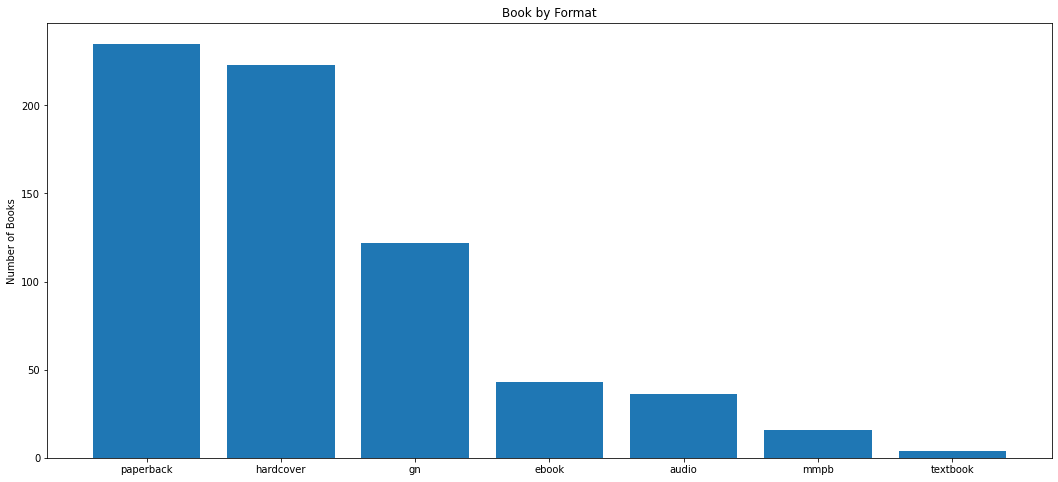

In [44]:
books_by_format(books, show=True)

In [45]:
def reading_speed_kde(df):
    """Creates a KDE plot to show distribution of reading speed across all days_to_finish values"""
    
    squared_df = df.copy()
    plt.close("all")
    plt.figure(figsize=(12, 8))
    sns.kdeplot(data=squared_df, x="days_to_finish", shade=True)
    mean_days = np.mean(df["days_to_finish"])
    median_days = np.median(df[["days_to_finish"]].dropna()["days_to_finish"])
    mode_days, mode_counts = stats.mode(df[["days_to_finish"]].dropna()["days_to_finish"])
    std_days = np.std(df["days_to_finish"])
    plt.axvline(mean_days, label=f"Mean Days to Finish a Book - {np.round(mean_days, 1)}", color="red", linestyle="--")
    plt.axvline(median_days, label=f"Median Days to Finish a Book - {median_days}", color="green", linestyle="--")
    plt.axvline(mode_days, label=f"Mode Days to Finish a Book - {mode_days[0]}", color="violet", linestyle="--")
    plt.axvline(mean_days + std_days, label="1 std away", color="orange", linestyle="--")
    plt.xlim([0, int(df["days_to_finish"].max())+10])
    plt.legend()
#     pdf_test.savefig()
    plt.show()

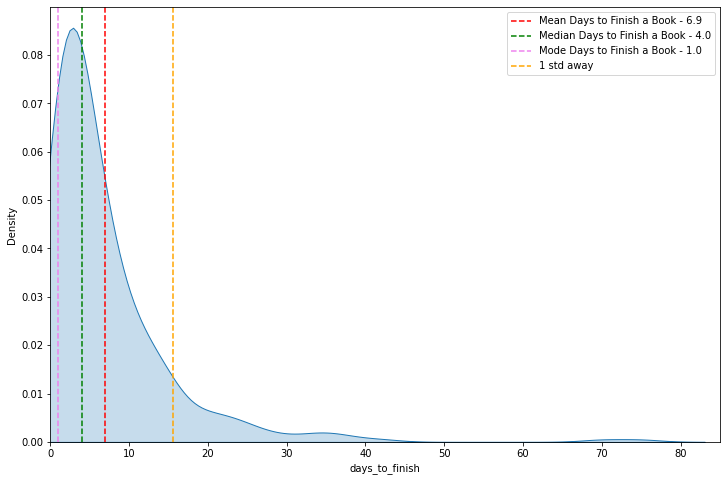

In [46]:
reading_speed_kde(books)